In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from arabic_reshaper import reshape
from bidi.algorithm import get_display

In [2]:
# Themes shit (fav color & font)
plt.style.use('dark_background')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.labelcolor'] = '#24d1ac'
plt.rcParams['xtick.color'] = '#24d1ac'
plt.rcParams['ytick.color'] = '#24d1ac'
plt.rcParams['axes.titlecolor'] = '#24d1ac'

In [3]:
def delete_low_answer_rows(df, threshold=0.7):
    print(f"len before: {len(df)}")
    answered_percentage = df.iloc[:, 3:].count(axis=1) / len(df.columns[3:])
    df_filtered = df[answered_percentage >= threshold]
    print(f"len after: {len(df_filtered)}")
    return df_filtered


In [4]:
file_path = 'data.csv'
df = pd.read_csv(file_path)
df_filtered = delete_low_answer_rows(df)

len before: 1520
len after: 1400


In [27]:
def plot_score_distribution(df):
    scores = df['Score'].astype(float)
    mean_score = scores.mean()
    std_dev = scores.std()
    min_score = scores.min()
    max_score = scores.max()

    plt.hist(scores, bins=20, edgecolor='black')
    plt.title('Score Distribution')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.axvline(x=mean_score, color='#d92693', linestyle='-')
    plt.axvline(x=mean_score + std_dev, color='#9f608a', linestyle='-')
    plt.axvline(x=mean_score - std_dev, color='#9f608a', linestyle='-')
    plt.savefig('distribution.jpg')
    plt.show()

    print(f"Total number of submissions after filtering: {len(scores)}")
    print(f"People Mira would marry with 90% threshold: {len(scores[scores <= 0.1 * 77])}")
    print(f"People Mira htt2fl mnhom with 90% threshold: {len(scores[scores > 0.1 * 77])}")
    print(f"Mean Score: {mean_score}")
    print(f"Standard Deviation: {std_dev}")
    print(f"Min Score: {min_score}")
    print(f"Max Score: {max_score}")

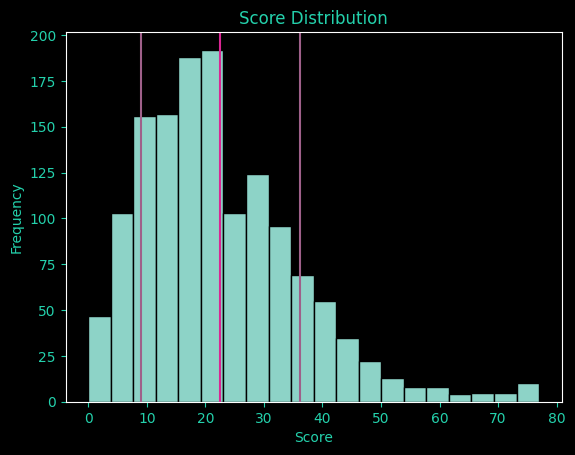

Total number of submissions after filtering: 1400
People Mira would marry with 90% threshold: 150
People Mira htt2fl mnhom with 90% threshold: 1250
Mean Score: 22.53857142857143
Standard Deviation: 13.59571257375031
Min Score: 0.0
Max Score: 77.0


In [28]:
plot_score_distribution(df_filtered)

In [7]:
def fix_arabic(text):
    return get_display(reshape(text))

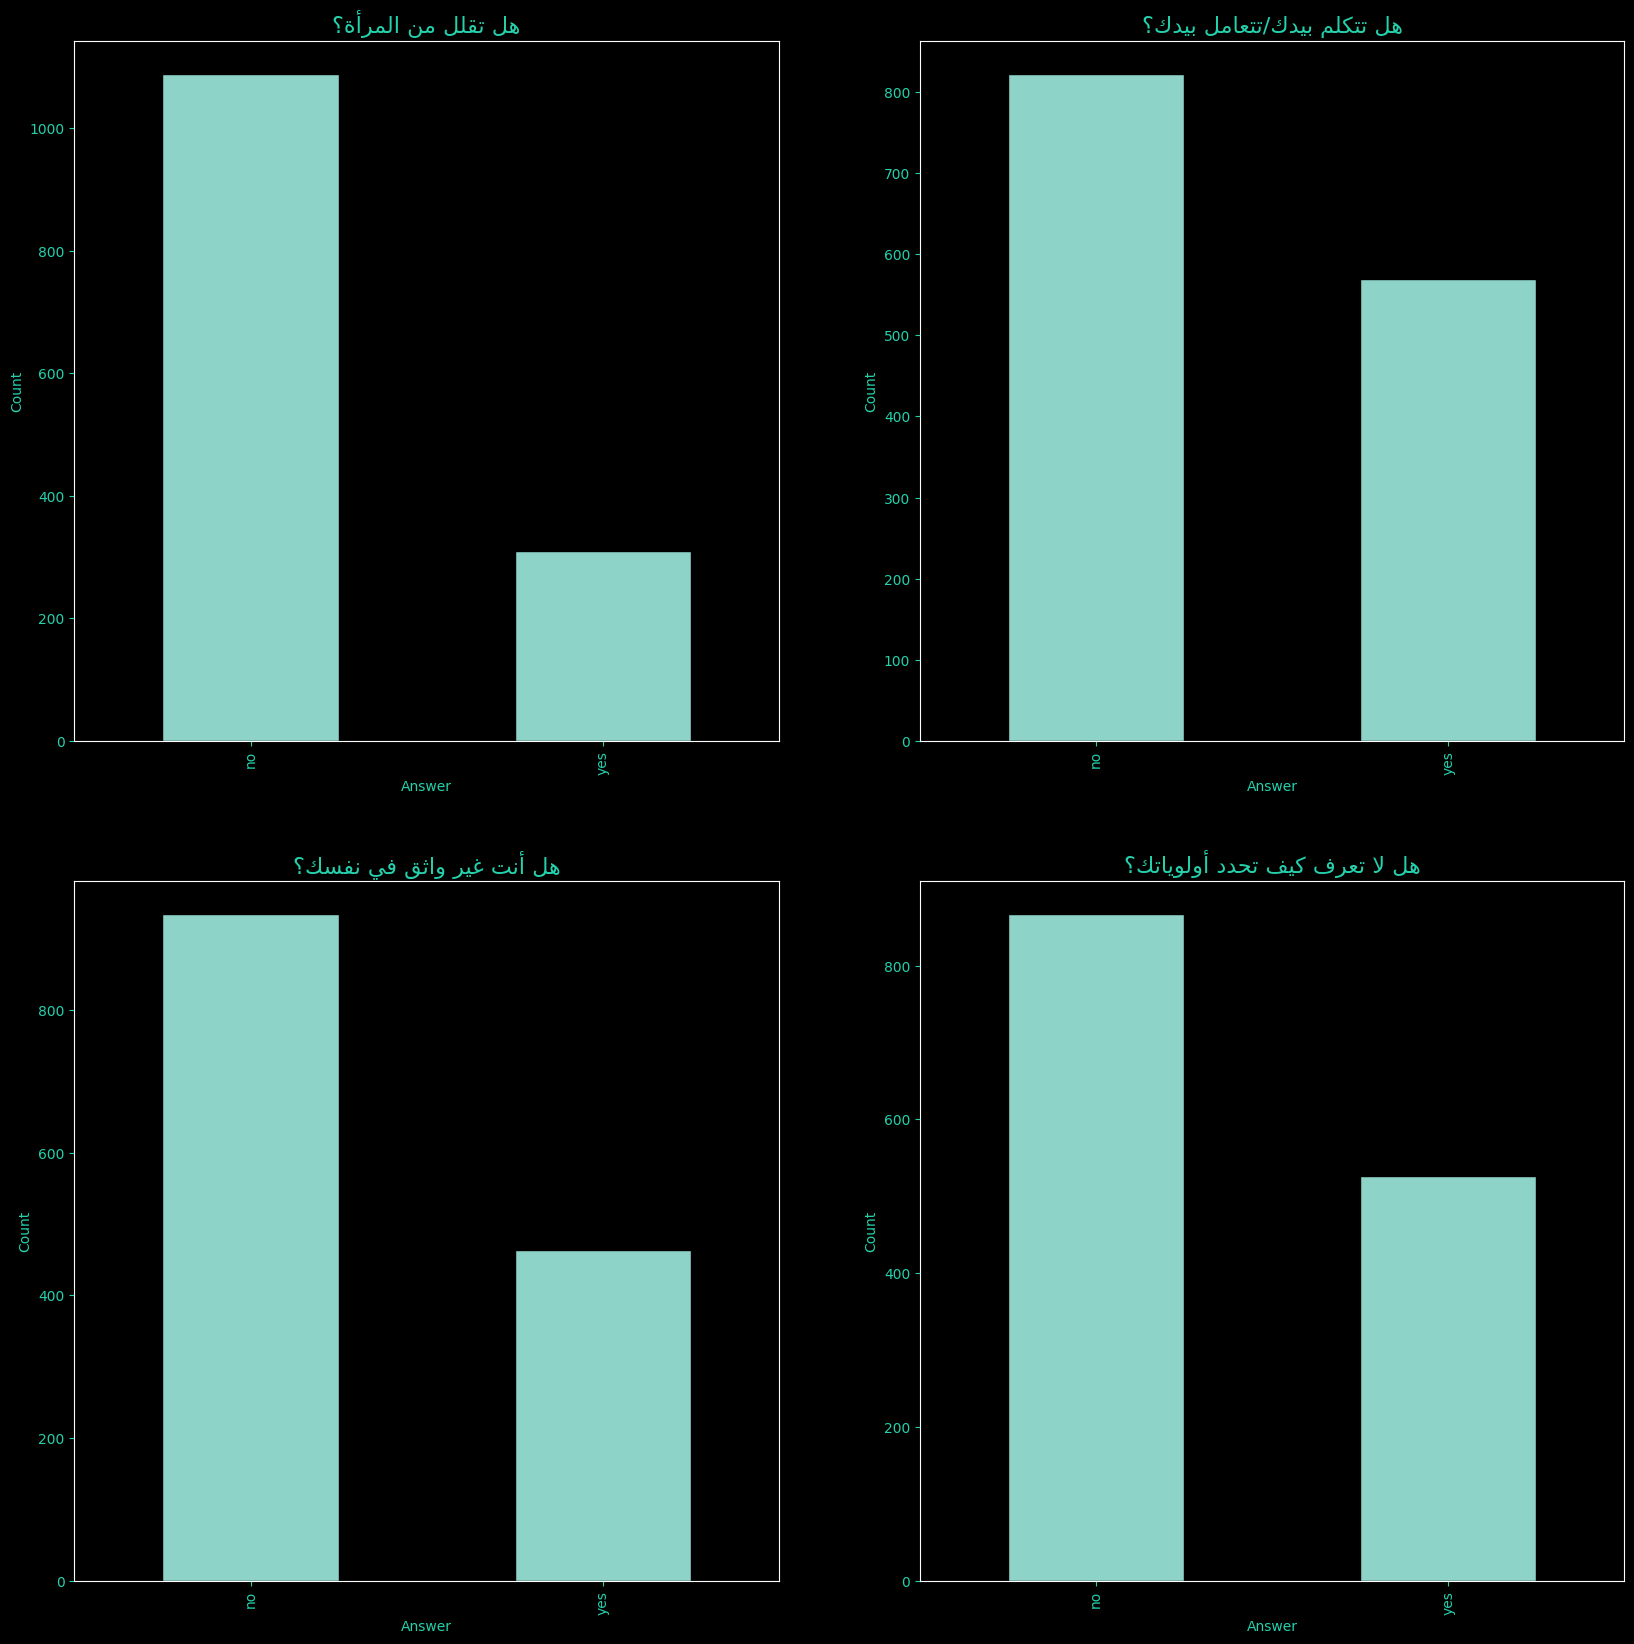

In [34]:
questions = df_filtered.columns[3:]
random_questions = np.random.choice(questions, 4, replace=False)
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
for i, question in enumerate(random_questions):
    answers = df_filtered[question].value_counts()
    answers = answers.rename({1.0: 'yes', 0.0: 'no'})
    answers.plot(kind='bar', edgecolor='black', ax=axs[i//2, i%2])
    question_ar = fix_arabic(question)
    axs[i//2, i%2].set_title(f'{question_ar}', fontdict=None, pad=None, fontsize=16)
    axs[i//2, i%2].set_xlabel('Answer')
    axs[i//2, i%2].set_ylabel('Count')
plt.savefig('random_4_ques.jpg')
plt.show()

In [38]:
def cluster_answers(df):
    # extract -> standardize -> PCA -> KMeans -> visualize
    X = df.iloc[:, 3:].apply(lambda x: pd.factorize(x)[0])
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_std)
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(X_pca)

    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_)
    plt.title('Clusters of Common Question Answers')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    cluster_counts = df.groupby(kmeans.labels_).apply(lambda x: x.iloc[:, 3:].apply(lambda y: y.value_counts(normalize=True)).mean())
    common_percentage = (cluster_counts.iloc[0] + cluster_counts.iloc[1]) / 2 * 100
    common_percentage = common_percentage.sort_values(ascending=False)
    
    plt.savefig('clusters.jpg')
    plt.show()

    for i, cluster in enumerate([0, 1]):
        print(f"Cluster {i + 1}:")
        cluster_answers_counts = df[kmeans.labels_ == cluster].iloc[:, 3:].apply(lambda x: x.value_counts(normalize=True).head())
        cluster_answers_counts.to_csv(f'cluster{i + 1}.csv')
        cluster_answers_counts = cluster_answers_counts.to_dict('index').values()
        cluster_answers_counts = sorted(cluster_answers_counts, key=lambda x: list(x.values())[0], reverse=True)
        final_list = []
        for i in range(0, len(list(cluster_answers_counts[0].keys()))):
            val = list(cluster_answers_counts[0].values())[i]
            ques = list(cluster_answers_counts[0].keys())[i]
            if val > 0.6:
                final_list.append([ques, val])
        
        final_list = sorted(final_list, key=lambda x: x[1], reverse=True)
        print(final_list[0:5])


/home/elt0khy/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


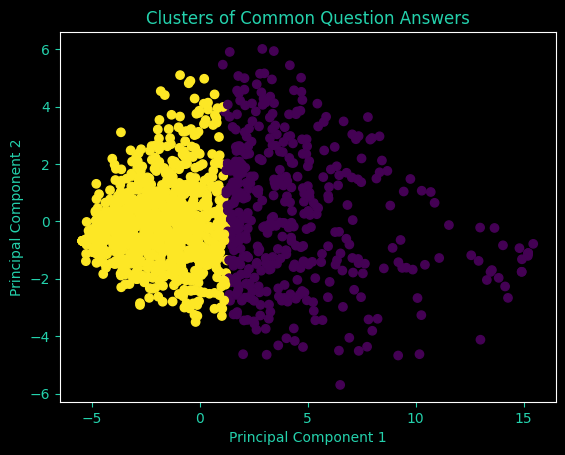

Cluster 1:
[['هل أنت بخيل؟', 0.8428571428571429], ['هل أنت غير نظيف/ أظافرك/ أسنانك/ رائحتك؟', 0.817966903073286], ['هل أنت ضد المقاومة/رقصت أمام لجنة من قبل/مع أي فصيل يقتل الأبرياء أو دعمت قتل أي مدني ولو بهزار؟', 0.8066037735849056], ['إذا كان لديك غمازة, هل تجلس تحزق أو إذا كانت عينك ملونة هل تظل تحدق أو تثقب بنظراتك؟', 0.8009478672985783], ['هل ترى المرأة أداة للجنس فقط؟', 0.7767220902612827]]
Cluster 2:
[['هل تصلي؟', 0.7942386831275721], ['هل تهزر هزار غير محترم؟', 0.685890834191555], ['هل أنت كثير الهزار؟', 0.6824254881808839], ['هل تسكتي عندما تزعل؟', 0.6210092687950567]]


In [39]:
cluster_answers(df_filtered)